In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#Libraries to create the Multi-class Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
#Import tensorflow and disable the v2 behavior and eager mode
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# Dataset

In [6]:
df = pd.read_csv('../static/playlists_metrics.csv')
df['tag'].unique()

array(['Calm', 'Dream', 'Energy', 'Epic', 'Happy', 'Hate', 'Love', 'Sad'],
      dtype=object)

In [7]:
df['tempo'] = df['tempo'].astype('float')

In [21]:
#tempo
df.loc[(df['tempo'] >= 0) & (df['tempo'] <= 60), 'speed'] = 1
df.loc[(df['tempo'] > 60) & (df['tempo'] <= 90), 'speed'] = 2
df.loc[(df['tempo'] > 90) & (df['tempo'] <= 120), 'speed'] = 3
df.loc[(df['tempo'] > 120) & (df['tempo'] <= 150), 'speed'] = 4
df.loc[(df['tempo'] > 150), 'speed'] = 5

#duracion
df['duration_minutes'] = round(df['duration_ms']/(1000 * 60),1)
df.loc[(df['duration_minutes'] >= 0) & (df['duration_minutes'] <= 2), 'duration'] = 1
df.loc[(df['duration_minutes'] > 2) & (df['duration_minutes'] <= 4), 'duration'] = 2
df.loc[(df['duration_minutes'] > 4) & (df['duration_minutes'] <= 6), 'duration'] = 3
df.loc[(df['duration_minutes'] > 6) , 'duration'] = 4


# Aplicar el Label Encoding manualmente
# label_mapping = {'Calm': 0, 'Dream': 1, 'Energy': 2, 'Epic':3, 'Happy':4, 'Hate':5, 'Love':6, 'Sad':7}
# df['tag_encode'] = df['tag'].map(label_mapping)

# remove some columns
df.drop(columns=[
    'type',
    'analysis_url',
    'track_href',
    'error.status', 
    'error.message', 
    'ts', 
    'uri',
     'tick', 
     'playlist', 
     'id',
     'key', 
     'time_signature', 
     'duration_ms', 
     'duration_minutes',
     'tempo'
    ,'speechiness',
    'mode']
    , inplace=True)
df.dropna(inplace=True)

#remove null values
df.dropna(inplace=True)

df.head()


,danceability,energy,loudness,acousticness,instrumentalness,liveness,valence,tag,speed,duration
0,0.565,0.636,-8.198,0.1070,0.000010,0.4470,0.525,Calm,5.0,2.0
1,0.681,0.372,-8.237,0.6400,0.000000,0.1690,0.476,Calm,3.0,2.0
2,0.686,0.127,-14.361,0.7540,0.000014,0.0573,0.372,Calm,3.0,2.0
3,0.738,0.482,-8.917,0.0266,0.621000,0.1060,0.352,Calm,3.0,3.0
4,0.668,0.260,-14.256,0.4530,0.000000,0.0621,0.368,Calm,3.0,2.0


In [22]:
# predictors and variables
X = df.drop(columns='tag')
y = df['tag']

In [23]:
# train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [24]:
# Standarize values
scl = StandardScaler()
scl.fit(X_train)
X_train_scl = scl.transform(X_train)
X_train_scl = pd.DataFrame(X_train_scl, columns=X.columns)
X_test_scl = scl.transform(X_test)
X_test_scl = pd.DataFrame(X_test_scl, columns=X.columns)

## Logistic Regression

In [25]:
logreg = LogisticRegression(max_iter=2000)
scores = cross_val_score(logreg, X_train_scl, y_train, cv=7)
print (scores.mean())

0.6036309673404422


In [26]:
scores

array([0.62427746, 0.60693642, 0.6057971 , 0.55652174, 0.61449275,
       0.6       , 0.6173913 ])

In [27]:
logreg.fit(X_train_scl, y_train)
predictions = logreg.predict(X_test_scl)

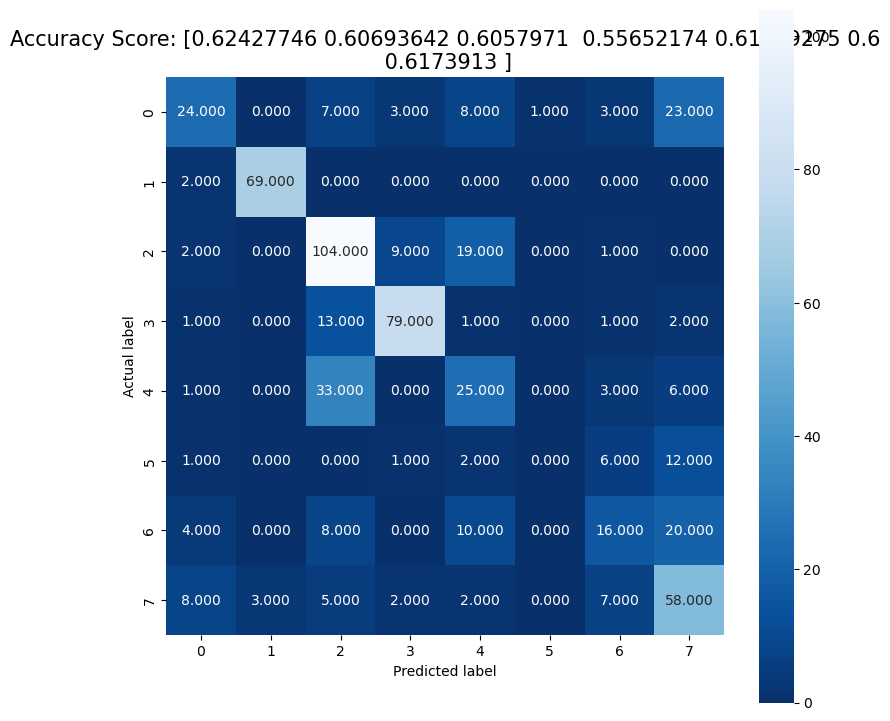

In [28]:
cm = confusion_matrix(y_test, predictions)
# print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(scores)
plt.title(all_sample_title, size = 15);

# Neural Network

In [29]:
X_test_scl

,danceability,energy,loudness,acousticness,instrumentalness,liveness,valence,speed,duration
0,-1.897604,-1.324195,-0.803106,-1.018063,1.638104,-0.431459,-1.363485,-1.401182,1.357579
1,-1.530984,0.178417,0.666219,-0.430986,-0.302211,-0.717106,-1.279944,1.681334,1.357579
2,0.025894,-1.798258,-2.343093,1.619916,1.715396,2.120107,-0.038876,-1.401182,-2.170666
3,0.939932,-0.512925,-0.012374,1.260593,0.897159,-0.447506,-0.489609,-1.401182,-0.406544
4,0.879666,0.594633,0.410194,-0.909990,-0.312872,-0.351221,1.216179,-0.373677,-0.406544
...,...,...,...,...,...,...,...,...,...
600,1.879081,-0.199000,-0.189287,-1.062840,-0.643270,-0.766853,0.870359,-0.373677,-0.406544
601,-1.922715,-1.775683,-2.298161,1.437491,1.723392,-0.541385,-1.373199,-1.401182,1.357579
602,1.396951,1.148413,0.931332,-0.986553,-0.643307,-0.644892,0.812075,0.653828,-0.406544
603,-0.652101,-1.348885,-0.262638,1.490007,-0.643365,-0.295054,-0.310870,-1.401182,-0.406544


In [51]:
columns_in_df = 9
number_of_moods = 8

#Function that creates the structure of the Neural Network
def base_model():
    #Create the model
    model = Sequential()
    #Add 1 layer with 8 nodes,input of 4 dim with relu function    
    model.add(Dense(units=8,input_dim=columns_in_df,activation='relu'))
    #Add another layer with 8 nodes,input of 4 dim with relu function    
    model.add(Dense(units=16,input_dim=columns_in_df,activation='relu'))
    #Add 1 layer with output 3 and softmax function
    model.add(Dense(number_of_moods,activation='softmax'))
    #Compile the model using logistic loss function and adam     optimizer, accuracy correspond to the metric displayed
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

#Configure the estimator with 300 epochs and 200 batchs. the build_fn takes the function defined above.
estimator = KerasClassifier(build_fn=base_model,epochs=300,batch_size=200)

C:\Users\marco\AppData\Local\Temp\ipykernel_24704\2724074313.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=base_model,epochs=300,batch_size=200)


In [59]:
len(X.columns)

9

In [52]:
base_model().summary()

Model: "sequential_974"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2912 (Dense)          (None, 8)                 80        
                                                                 
 dense_2913 (Dense)          (None, 16)                144       
                                                                 
 dense_2914 (Dense)          (None, 8)                 136       
                                                                 
Total params: 360
Trainable params: 360
Non-trainable params: 0
_________________________________________________________________


In [68]:
print("Accuraccy: %.2f%% (Std. Dev. %.2f%%)" % (results.mean()*100,results.std()*100))

Accuraccy: 60.82% (Std. Dev. 2.60%)


In [106]:
info = "Accuraccy: %.2f%% (Std. Dev. %.2f%%)" % (results.mean()*100,results.std()*100)
info

'Accuraccy: 60.82% (Std. Dev. 2.60%)'

In [69]:
print(base_model().summary() )

Model: "sequential_982"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2936 (Dense)          (None, 8)                 80        
                                                                 
 dense_2937 (Dense)          (None, 16)                144       
                                                                 
 dense_2938 (Dense)          (None, 8)                 136       
                                                                 
Total params: 360
Trainable params: 360
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
info = print(base_model().summary())

Model: "sequential_992"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2966 (Dense)          (None, 8)                 80        
                                                                 
 dense_2967 (Dense)          (None, 16)                144       
                                                                 
 dense_2968 (Dense)          (None, 8)                 136       
                                                                 
Total params: 360
Trainable params: 360
Non-trainable params: 0
_________________________________________________________________
None


In [104]:
# def summary(model: tf.keras.Model) -> str:
#   summary = []
#   model.summary(print_fn=lambda x: summary.append(x))
#   return '\n'.join(summary)

In [53]:
#Evaluate the model using KFold cross validation
kfold = KFold(n_splits=5,shuffle=True)
results = cross_val_score(estimator,X,y,cv=kfold)
print("%.2f%% (%.2f%%)" % (results.mean()*100,results.std()*100))

Train on 2417 samples
Epoch 1/300
2417/2417 [==============================] - 1s 520us/sample - loss: 3.1983 - acc: 0.1341
Epoch 2/300
2417/2417 [==============================] - 0s 65us/sample - loss: 2.8658 - acc: 0.1212
Epoch 3/300
2417/2417 [==============================] - 0s 72us/sample - loss: 2.6217 - acc: 0.1101
Epoch 4/300
2417/2417 [==============================] - 0s 64us/sample - loss: 2.4158 - acc: 0.1465
Epoch 5/300
2417/2417 [==============================] - 0s 85us/sample - loss: 2.2435 - acc: 0.2201
Epoch 6/300
2417/2417 [==============================] - 0s 72us/sample - loss: 2.1041 - acc: 0.2325
Epoch 7/300
2417/2417 [==============================] - 0s 68us/sample - loss: 2.0132 - acc: 0.2346
Epoch 8/300
2417/2417 [==============================] - 0s 59us/sample - loss: 1.9586 - acc: 0.3111
Epoch 9/300
2417/2417 [==============================] - 0s 104us/sample - loss: 1.9228 - acc: 0.3211
Epoch 10/300
2417/2417 [==============================] - 0s 65us/s

C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Train on 2417 samples
Epoch 1/300
2417/2417 [==============================] - 1s 397us/sample - loss: 2.1766 - acc: 0.1506
Epoch 2/300
2417/2417 [==============================] - 0s 48us/sample - loss: 2.1061 - acc: 0.1469
Epoch 3/300
2417/2417 [==============================] - 0s 52us/sample - loss: 2.0559 - acc: 0.1489
Epoch 4/300
2417/2417 [==============================] - 0s 48us/sample - loss: 2.0093 - acc: 0.1643
Epoch 5/300
2417/2417 [==============================] - 0s 51us/sample - loss: 1.9640 - acc: 0.1936
Epoch 6/300
2417/2417 [==============================] - 0s 51us/sample - loss: 1.9177 - acc: 0.2325
Epoch 7/300
2417/2417 [==============================] - 0s 46us/sample - loss: 1.8759 - acc: 0.3128
Epoch 8/300
2417/2417 [==============================] - 0s 53us/sample - loss: 1.8378 - acc: 0.3409
Epoch 9/300
2417/2417 [==============================] - 0s 51us/sample - loss: 1.8011 - acc: 0.3517
Epoch 10/300
2417/2417 [==============================] - 0s 62us/sa

In [119]:
estimator

In [35]:
# # Standarize values
# scl = StandardScaler()
# scl.fit(X_train)
# X_scl = scl.transform(X)
# X_scl = pd.DataFrame(X_scl, columns=X.columns)

# columns_in_df = 9
# number_of_moods = 8

# def build_clf(unit):
#     # creating the layers of the NN
#     ann = tf.keras.models.Sequential()
#     ann.add(tf.keras.layers.Dense(units=unit, activation='relu'))
#     ann.add(tf.keras.layers.Dense(units=unit, activation='relu'))
#     ann.add(tf.keras.layers.Dense(units=number_of_moods, activation='sigmoid'))
#     ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#     return ann

# model=KerasClassifier(build_fn=build_clf)

# params={'batch_size':[20, 50, 100],
# 		'nb_epoch':[300, 400],
# 		'unit':[5,10, 15],
		
# 		}


# gs=GridSearchCV(estimator=model, param_grid=params, cv=10)
# # now fit the dataset to the GridSearchCV object.
# gs = gs.fit(X_scl, y)


# best_params=gs.best_params_
# accuracy=gs.best_score_

C:\Users\marco\AppData\Local\Temp\ipykernel_24704\2600700114.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model=KerasClassifier(build_fn=build_clf)


# scikeras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.datasets import make_classification
def model():
    #Create the model
    model = Sequential()
    #Add 1 layer with 8 nodes,input of 4 dim with relu function
    model.add(Dense(units=10,input_dim=20,activation='relu'))
    #Add another layer with 8 nodes,input of 4 dim with relu function
    model.add(Dense(units=20,input_dim=20,activation='relu'))
    #Add 1 layer with output 3 and softmax function
    model.add(Dense(2,activation='softmax'))
    #Compile the model using logistic loss function and adam     optimizer, accuracy correspond to the metric displayed
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model
    
# estimator = KerasClassifier(build_fn=model, epochs=100, batch_size=5)
estimator = KerasClassifier(model=model, epochs=100, batch_size=5, verbose=0)
X, y = make_classification()
estimator.fit(X, y)

# This is what you need
# estimator.model.summary()
estimator.model_.summary()